In [48]:
!pip install seaborn

     |████████████████████████████████| 285 kB 6.0 MB/s eta 0:00:01


In [49]:
import os
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
import h5py
import random
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#import torchio as tio
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
tf.__version__

'2.4.0'

Balance trainingsets 
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

train on 80% of all training images

### Import data from HD5File

Checking the data

In [2]:
PATH_3D_H5 = 'Images/tof_data.hdf5'

In [3]:
with h5py.File(PATH_3D_H5, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)
    print(dd['stroke'].shape)

['X', 'pat', 'path', 'stroke']
(508, 128, 112, 40)
(508,)


In [4]:
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File(PATH_3D_H5, 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    
    # Image matrices
    X = h5["X"][:]
    # Patient ID's
    pat = h5["pat"][:]
    # Path to images
    path = decode_data(h5["path"][:])
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
    
print(len(X), len(Y_pat), len(pat), len(path))

H5-file:  ['X', 'pat', 'path', 'stroke']
508 508 508 508


### Train, validation, test split (vgl. NB from Lisa)

There are 508 patients with TOF-MRA images. We split the dataset in a training and test set.
- Training set: 407 images (~80%) -> 281 stroke, 126 non-stroke
- Test set: 101 images (~20%) -> 70 stroke, 31 non-stroke

In every set there is the same percentage of stroke patients vs. non stroke patients (approx. 69% vs. 31%)

In [5]:
# consider stroke and no-stroke patients separately:
idx = np.where(Y_pat == 1)[0]
stroke_patients = np.unique(pat[idx])
idx = np.where(Y_pat == 0)[0]
non_stroke_patients = np.unique(pat[idx])
print(len(stroke_patients), len(non_stroke_patients))

351 157


In [6]:
# randomly shuffle the stroke and non-stroke patients
np.random.seed(1)
stroke_patients_test = np.random.choice(stroke_patients, size=len(stroke_patients), replace=False)
non_stroke_patients_test = np.random.choice(non_stroke_patients, size=len(non_stroke_patients), replace=False)

In [7]:
#test set
np.random.seed(1)
test_tmp = np.concatenate([stroke_patients_test[:70], non_stroke_patients_test[:31]], axis=0)
test = np.random.choice(test_tmp, size=len(test_tmp), replace=False)
len(test)

101

In [8]:
stroke_patients_run = [i for i in stroke_patients if i not in test]
non_stroke_patients_run = [i for i in non_stroke_patients if i not in test]

# randomply shuffle the data
np.random.seed(100)
stroke_patients_tmp = np.random.choice(stroke_patients_run, size=len(stroke_patients_run), replace=False)
non_stroke_patients_tmp = np.random.choice(non_stroke_patients_run, size=len(non_stroke_patients_run), replace=False)
print(len(stroke_patients_tmp), len(non_stroke_patients_tmp))

281 126


In [9]:
train_tmp = np.concatenate([stroke_patients_tmp,non_stroke_patients_tmp], axis=0)
len(train_tmp)

407

In [10]:
# randomly shuffle the datasets such that stroke and no-stroke patients are mixed
np.random.seed(100)
train = np.random.choice(train_tmp, size=len(train_tmp), replace=False)
test = np.random.choice(test, size=len(test), replace=False)
print(len(train), len(test))

407 101


In [11]:
def get_datasets(set_i, X, Y_pat, pat, path):
    Y_pat_set = []
    pat_set = []
    path_set = []
    # Find the indices corresponding to the patient_i in set_i
    idx = [i for i, pat_i in enumerate(pat) if pat_i in set_i]
    X_set = X[idx,:,:,:]
    for i in idx:
        Y_pat_set.append(Y_pat[i])
        pat_set.append(pat[i])
        path_set.append(path[i])     
    return(X_set, np.array(Y_pat_set), np.array(pat_set), np.array(path_set))

In [249]:
X_train, Y_train, pat_train, path_train = get_datasets(train, X, Y_pat, pat, path)

In [250]:
X_test, Y_test, pat_test, path_test = get_datasets(test, X, Y_pat, pat, path)

### Preprocess data

Add dimension to arrays for 3D tensor

In [45]:
X_train = X_train[:,:,:,:,np.newaxis] 
X_test = X_test[:,:,:,:,np.newaxis] 

In [251]:
#IMAGE_DIMENSION = (64, 56, 20)
#IMAGE_DIMENSION = (96, 84, 30)
IMAGE_DIMENSION = (128, 112, 40)

In [184]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_width = IMAGE_DIMENSION[0]
    desired_height = IMAGE_DIMENSION[1]
    desired_depth = IMAGE_DIMENSION[2]
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [185]:
X_train = np.array([resize_volume(img) for img in X_train])

In [186]:
X_train.shape

(407, 64, 56, 20)

In [187]:
X_test = np.array([resize_volume(img) for img in X_test])

In [188]:
X_test.shape

(101, 64, 56, 20)

In [32]:
def plot_3d_slices(data):
    fig = plt.figure(figsize = (12, 20)) 
    columns = 5
    rows = 4
    fig_all = []
    for i in range(1, 20):
        img = data[i]
        fig_all.append(fig.add_subplot(rows, columns, i))
        plt.imshow(img, cmap = 'gray')
    plt.show()

### Data Augmentation

- Rotate volumes by random angles

In [112]:
X = X_train[1,:,:,:,np.newaxis] 
X.shape

(128, 112, 40, 1)

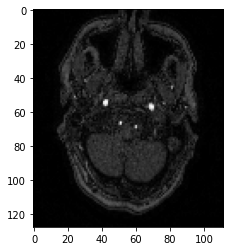

In [40]:
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X[:, :, 10]), cmap="gray")

Zoom images

In [107]:
# zoom
def random_zoom3d(X_im, min_zoom, max_zoom):
    z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)

In [120]:
X_aug = random_zoom3d(X, 0.8, 1.3)
#plot_slices(4, 10, 128, 112, X_aug[:, :, :])
#fig, ax = plt.subplots()
#pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Rotate images

In [108]:
# rotate
def random_rotate3d(X_im, min_angle_xy, max_angle_xy, min_angle_xz, max_angle_xz, min_angle_yz, max_angle_yz):
    angle_xy = np.random.uniform(min_angle_xy, max_angle_xy)
    angle_xz = np.random.uniform(min_angle_xz, max_angle_xz)
    angle_yz = np.random.uniform(min_angle_yz, max_angle_yz)
    rotation_axis = np.random.choice([0,1,2])
    if(rotation_axis == 0):
        X_im = ndimage.rotate(X_im, angle = angle_xy, axes = (0,1), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 1):
        X_im = ndimage.rotate(X_im, angle = angle_xz, axes = (0,2), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 2):
        X_im = ndimage.rotate(X_im, angle = angle_yz, axes = (1,2), mode = "nearest", reshape = False, order = 3)
    return X_im

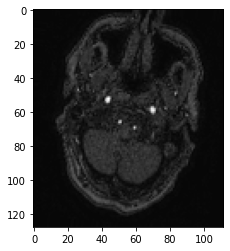

In [36]:
X_aug = random_rotate3d(X, -20, 20, -5, 5, -5, 5)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Shifting images

In [109]:
# shifting
def random_shift3d(X_im, min_shift_x, max_shift_x, min_shift_y, max_shift_y, min_shift_z, max_shift_z):
    x_shift = np.random.uniform(min_shift_x, max_shift_x)
    y_shift = np.random.uniform(min_shift_y, max_shift_y)
    z_shift = np.random.uniform(min_shift_z, max_shift_z)
    return ndimage.shift(X_im, [x_shift, y_shift, z_shift, 0], mode = "nearest", order = 0)

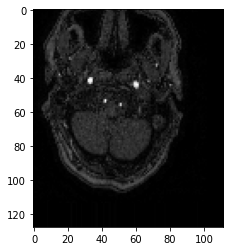

In [39]:
X_aug = random_shift3d(X, -20, 20, -20, 20, 0, 0)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Flipping images

In [110]:
def random_flip3d(X_im):
    axis = np.random.choice([0,1])
    if(axis == 0): # vertical flip
        X_im = X_im[:,::-1,:,:]
        # X_im = X_im[::-1,:,:,:] #horizontal
        # X_im = np.asarray(X_im).swapaxes(0, 1)#left, right flip
    return X_im

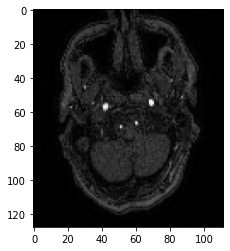

In [45]:
X_aug = random_flip3d(X)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Gauss filter

In [111]:
# Gauss filter (Glättung, Mittelwertberechnung per Pixel basierend auf umgebenden Pixeln ausgewählt mit Gaussfkt.)
def random_gaussianfilter3d(X_im, sigma_max):
    sigma = np.random.uniform(0, sigma_max)
    return ndimage.gaussian_filter(X_im, sigma, mode = "nearest")

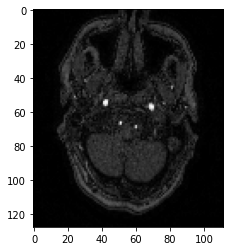

In [52]:
X_aug = random_gaussianfilter3d(X, 0.2)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

In [80]:
@tf.function
def zoom(volume):
    """Rotate the volume by a few degrees"""

    def random_zoom3d(volume, min_zoom = 0.8, max_zoom = 1.3):
        z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
        zoom_matrix = np.array([[z, 0, 0, 0],
                                [0, z, 0, 0],
                                [0, 0, z, 0],
                                [0, 0, 0, 1]])
        return ndimage.affine_transform(volume, zoom_matrix, mode = "nearest", order = 1)
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(random_zoom3d, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [90]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def random_rotate3d(X_im, min_angle_xy = -20, max_angle_xy = 20, min_angle_xz = -5, max_angle_xz = 5, min_angle_yz = -5, max_angle_yz = 5):
        angle_xy = np.random.uniform(min_angle_xy, max_angle_xy)
        angle_xz = np.random.uniform(min_angle_xz, max_angle_xz)
        angle_yz = np.random.uniform(min_angle_yz, max_angle_yz)
        rotation_axis = np.random.choice([0,1,2])
        if(rotation_axis == 0):
            X_im = ndimage.rotate(X_im, angle = angle_xy, axes = (0,1), mode = "nearest", reshape = False, order = 3)
        if(rotation_axis == 1):
            X_im = ndimage.rotate(X_im, angle = angle_xz, axes = (0,2), mode = "nearest", reshape = False, order = 3)
        if(rotation_axis == 2):
            X_im = ndimage.rotate(X_im, angle = angle_yz, axes = (1,2), mode = "nearest", reshape = False, order = 3)
        return X_im
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(random_rotate3d, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [252]:
@tf.function
def augment_3d(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        #volume = random_zoom3d(volume, 0.8, 1.3)
        volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
        volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
        #volume = random_flip3d(volume)
        #volume = random_gaussianfilter3d(volume, 0.2)
        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [92]:
@tf.function
def augment_3d(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        rand = np.random.randint(0,6)
        if rand == 0:
            volume = random_zoom3d(volume, 0.8, 1.3)
        if rand == 1:
            volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
        if rand == 2:
            volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
        if rand == 3:
            volume = random_flip3d(volume)
        if rand == 4:
            volume = random_gaussianfilter3d(volume, 0.2)
        if rand == 5:
            volume = volume
        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [253]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    volume = augment_3d(volume)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

### Define data loaders

Balanced dataset with numpy

In [178]:
bool_train_labels = Y_train != 0
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]
pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [85]:
ids = np.arange(len(neg_features))
choices = np.random.choice(ids, len(pos_features))
res_neg_features = neg_features[choices]
res_neg_labels = neg_labels[choices]

In [86]:
resampled_features = np.concatenate([pos_features, res_neg_features], axis=0)
resampled_labels = np.concatenate([pos_labels, res_neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

In [95]:
# Define data loaders.
#train_loader = tf.data.Dataset.from_tensor_slices((resampled_features, resampled_labels))
train_loader = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [16]:
train_loader

<TensorSliceDataset shapes: ((128, 112, 40), ()), types: (tf.float64, tf.int64)>

In [96]:
batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [18]:
train_dataset

<PrefetchDataset shapes: ((None, 128, 112, 40, 1), (None,)), types: (tf.float64, tf.int64)>

Dimension of the CT scan is: (128, 112, 40, 1)


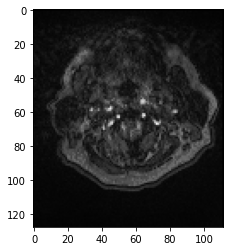

In [56]:
data = train_dataset.take(15)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 0]), cmap="gray")

In [ ]:
data = train_dataset.take(10)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(image[:, :, 10]), cmap="gray")
cbar = fig.colorbar(pos, ax=ax)
cbar.minorticks_on()
fig = plt.gcf()
plt.show()
#fig.savefig('Rotatet volume', dpi = 100,bbox_inches='tight')

In [19]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    fig = plt.gcf()
    plt.show()
    fig.savefig('Rotatet slices', dpi = 100,bbox_inches='tight')

In [ ]:
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 112, image[:, :, :40])

Balanced dataset with tf.data

In [254]:
bool_train_labels = Y_train != 0
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]
pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [255]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [256]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
counter = tf.data.experimental.Counter()
#resampled_ds = tf.data.Dataset.zip((resampled_ds, (counter, counter)))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

batch_size = 8
# Augment the on the fly during training.
resampled_data = (
    
    resampled_ds.map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [257]:
pos = len(pos_features)
resampled_steps_per_epoch = np.ceil(2.0*pos/batch_size)
resampled_steps_per_epoch

71.0

### Train CNN

In [258]:
w = IMAGE_DIMENSION[0]
h = IMAGE_DIMENSION[1]
d = IMAGE_DIMENSION[2]

In [259]:
def get_model(width=w, height=h, depth=d):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",padding = 'same')(inputs)
    x = layers.MaxPool3D(pool_size=2, padding = 'valid')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.MaxPool3D(pool_size=2, padding = 'valid')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.MaxPool3D(pool_size=2, padding = 'valid')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.MaxPool3D(pool_size=2, padding = 'valid')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x) #oder 0.6

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [260]:
# Build model.
model = get_model(width=w, height=h, depth=d)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 112, 40, 1)] 0         
_________________________________________________________________
conv3d_52 (Conv3D)           (None, 128, 112, 40, 64)  1792      
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 64, 56, 20, 64)    0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 64, 56, 20, 64)    256       
_________________________________________________________________
conv3d_53 (Conv3D)           (None, 64, 56, 20, 64)    110656    
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 32, 28, 10, 64)    0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 32, 28, 10, 64)    256   

In [261]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)

In [262]:
metrics = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=metrics
)


In [263]:
# Define callbacks.
callback_list = [
    #keras.callbacks.EarlyStopping(monitor="val_auc", patience=15),
    keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only=True),
    #keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10)   
]

In [38]:
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1, callbacks=callback_list)

Epoch 1/50
102/102 [==============================] - 24s 200ms/step - loss: 0.6569 - accuracy: 0.6626 - auc: 0.5731 - val_loss: 0.8451 - val_accuracy: 0.6931 - val_auc: 0.5000
Epoch 2/50
102/102 [==============================] - 22s 196ms/step - loss: 0.6247 - accuracy: 0.6942 - auc: 0.5710 - val_loss: 1.4213 - val_accuracy: 0.6931 - val_auc: 0.5327
Epoch 3/50
102/102 [==============================] - 21s 195ms/step - loss: 0.6055 - accuracy: 0.6887 - auc: 0.6458 - val_loss: 1.3714 - val_accuracy: 0.6931 - val_auc: 0.5000
Epoch 4/50
102/102 [==============================] - 21s 198ms/step - loss: 0.5726 - accuracy: 0.7232 - auc: 0.5571 - val_loss: 1.5028 - val_accuracy: 0.6931 - val_auc: 0.5000
Epoch 5/50
102/102 [==============================] - 22s 197ms/step - loss: 0.6369 - accuracy: 0.6493 - auc: 0.5720 - val_loss: 1.6513 - val_accuracy: 0.6931 - val_auc: 0.5237
Epoch 6/50
102/102 [==============================] - 21s 196ms/step - loss: 0.6249 - accuracy: 0.6690 - auc: 0.571

### Balanced model

In [264]:
output_layer = model.layers[-1] 
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [265]:
epochs = 70
model.fit(
    resampled_data,
    validation_data=validation_dataset,
    epochs=epochs,
    steps_per_epoch=resampled_steps_per_epoch,
    verbose=1, callbacks=callback_list)

Epoch 1/70
71/71 [==============================] - 76s 968ms/step - loss: 0.7040 - accuracy: 0.4873 - auc: 0.5144 - val_loss: 0.6481 - val_accuracy: 0.6931 - val_auc: 0.5253
Epoch 2/70
71/71 [==============================] - 66s 926ms/step - loss: 0.6964 - accuracy: 0.5446 - auc: 0.5560 - val_loss: 0.7328 - val_accuracy: 0.6931 - val_auc: 0.5000
Epoch 3/70
71/71 [==============================] - 66s 933ms/step - loss: 0.6731 - accuracy: 0.5783 - auc: 0.5945 - val_loss: 0.9758 - val_accuracy: 0.6931 - val_auc: 0.5000
Epoch 4/70
71/71 [==============================] - 66s 929ms/step - loss: 0.6636 - accuracy: 0.5576 - auc: 0.6208 - val_loss: 1.5690 - val_accuracy: 0.6931 - val_auc: 0.5000
Epoch 5/70
71/71 [==============================] - 66s 927ms/step - loss: 0.6658 - accuracy: 0.6029 - auc: 0.6301 - val_loss: 1.4168 - val_accuracy: 0.6931 - val_auc: 0.4956
Epoch 6/70
71/71 [==============================] - 66s 927ms/step - loss: 0.6422 - accuracy: 0.6129 - auc: 0.6634 - val_loss

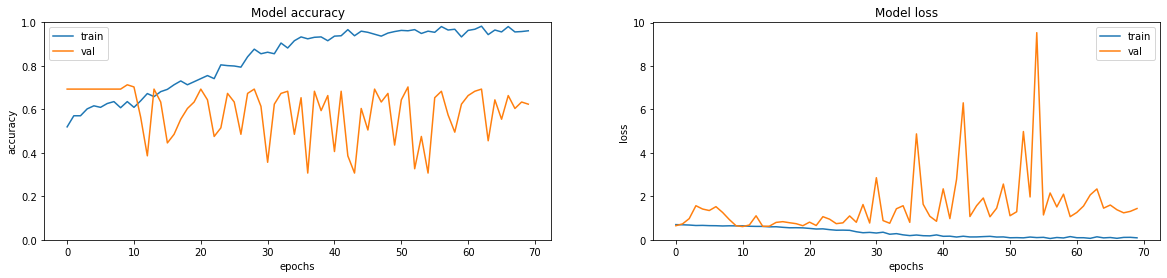

In [266]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
ax[0].set_ylim(0,1)
ax[1].set_ylim(0)

p = '3D_CNN_balanciert_ '+str(IMAGE_DIMENSION)
fig.savefig(p)

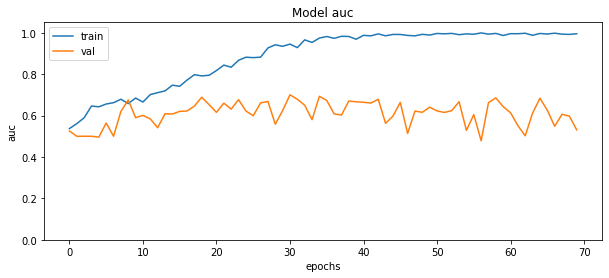

In [267]:
metric = "auc"
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(model.history.history[metric])
ax.plot(model.history.history["val_" + metric])
ax.set_title("Model {}".format(metric))
ax.set_xlabel("epochs")
ax.set_ylabel(metric)
ax.legend(["train", "val"])
ax.set_ylim(0,1.05)

p = '3D_CNN_balanciert_auc_'+str(IMAGE_DIMENSION)
fig.savefig(p)

### Make prediction and compute confusion matrix

In [269]:
X_test_test = np.expand_dims(X_test, axis = 4)
X_test_test.shape

(101, 128, 112, 40, 1)

In [226]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap = "Blues", cbar = False)
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [272]:
#model.load_weights("3d_image_classification.h5")
test_predictions_baseline = model.predict(X_test_test, batch_size=batch_size)
y_pred = (test_predictions_baseline > 0.5).astype(np.int)

loss :  0.6085965633392334
accuracy :  0.7029703259468079
auc :  0.6006912589073181

True Negatives:  3
False Positives:  28
False Negatives:  2
True Positives:  68


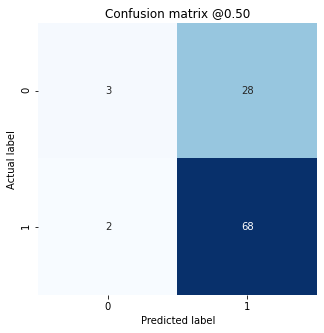

In [273]:
baseline_results = model.evaluate(X_test_test, Y_test,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_test, test_predictions_baseline)

In [229]:
tf.math.confusion_matrix(labels = Y_test, predictions = y_pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[13, 18],
       [14, 56]], dtype=int32)>